In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, \
    average_precision_score, accuracy_score, precision_score,f1_score,recall_score

# TFC fine tuning

In [2]:
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/model')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/trainer')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/dataloader')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/SleepEEG_Configs')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/MddEEG_Configs')

In [3]:
import torch
from torch import nn
from model import TFC, target_classifier
from SleepEEG_Configs import Config as Configs
# from MddEEG_Configs import Config as Configs
from dataloader import data_generator
from trainer import model_finetune, model_test


In [4]:
def one_hot_encoding(X):
    X = [int(x) for x in X]
    n_values = np.max(X) + 1
    b = np.eye(n_values)[X]
    return b


def model_test_knn(emb_finetune, label_finetune, emb_test, label_test):


    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(emb_finetune, label_finetune)
    knn_acc_train = neigh.score(emb_finetune, label_finetune)

    representation_test = emb_test.detach().cpu().numpy()

    knn_result = neigh.predict(representation_test)
    knn_result_score = neigh.predict_proba(representation_test)
    one_hot_label_test = one_hot_encoding(label_test)

    knn_acc = accuracy_score(label_test, knn_result)
    precision = precision_score(label_test, knn_result, average='macro', )
    recall = recall_score(label_test, knn_result, average='macro', )
    F1 = f1_score(label_test, knn_result, average='macro')
    auc = roc_auc_score(one_hot_label_test, knn_result_score, average="macro", multi_class="ovr")
    prc = average_precision_score(one_hot_label_test, knn_result_score, average="macro")
    print('KNN Testing: Acc=%.4f| Precision = %.4f | Recall = %.4f | F1 = %.4f | AUROC= %.4f | AUPRC=%.4f'%
                  (knn_acc, precision, recall, F1, auc, prc))

    return F1

In [5]:
torch.backends.mps.is_available()

True

### define configs

In [6]:
SEED = 42
arch = 'sleepedf2mdd'
load_from = '../models/SleepEEG_2_Epilepsy/pretrained/'
sourcedata_path = '../datasets/SleepEEG/'
targetdata_path = '../datasets/MddEEG/'
training_mode = 'fine_tune_test'
subset = False


device = torch.device("mps")
configs = Configs()

### create and load TFC model and finetuning classifier

In [7]:
TFC_model = TFC(configs).to(device)
chkpoint = torch.load(os.path.join(load_from, "ckp_last.pt"), map_location=device)
pretrained_dict = chkpoint["model_state_dict"]
TFC_model.load_state_dict(pretrained_dict)


classifier = target_classifier(configs).to(device)

### create optimizers

In [8]:
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)

criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, 'min')

### load datasets

In [9]:
train_dl, valid_dl, test_dl = data_generator(sourcedata_path, targetdata_path, configs, training_mode, subset=subset)

### finetune and test loop

In [10]:
performance_list = []
total_f1 = []
KNN_f1 = []


for epoch in range(1, configs.num_epoch + 1):
    valid_loss, emb_finetune, label_finetune, F1 = model_finetune(TFC_model, model_optimizer, 
                                                                valid_dl, configs, device, training_mode, 
                                                                classifier, classifier_optimizer)

    scheduler.step(valid_loss)


            
    if len(total_f1) == 0 or F1 > max(total_f1):
        print('update fine-tuned model')
        os.makedirs('experiments_logs/finetunemodel/', exist_ok=True)
        torch.save(TFC_model.state_dict(), 'experiments_logs/finetunemodel/' + arch + '_model.pt')
        torch.save(classifier.state_dict(), 'experiments_logs/finetunemodel/' + arch + '_classifier.pt')
    
    
    total_f1.append(F1)


    TFC_model.load_state_dict(torch.load('experiments_logs/finetunemodel/' + arch + '_model.pt'))
    classifier.load_state_dict(torch.load('experiments_logs/finetunemodel/' + arch + '_classifier.pt'))
    
    test_loss, test_acc, test_auc, test_prc, emb_test, label_test, performance = model_test(TFC_model, test_dl, configs, device, training_mode,
                                                             classifier=classifier, classifier_optimizer=classifier_optimizer)
    
    F1_knn = model_test_knn(emb_finetune, label_finetune, emb_test, label_test)
    KNN_f1.append(F1_knn)
    
    performance_list.append(performance)


    # break


/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/loss.py:119: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)


 Finetune: loss = 6.1514| Acc=77.5502 | Precision = 86.6667 | Recall = 86.6667 | F1 = 86.6667| AUROC=86.8692 | AUPRC = 86.9440
update fine-tuned model
MLP Testing: Acc=81.8801| Precision = 82.0977 | Recall = 81.8406 | F1 = 81.8353 | AUROC= 90.8356 | AUPRC=91.2910
KNN Testing: Acc=0.8235| Precision = 0.8251 | Recall = 0.8232 | F1 = 0.8232 | AUROC= 0.8966 | AUPRC=0.8709
 Finetune: loss = 4.4768| Acc=81.9478 | Precision = 84.9277 | Recall = 85.0446 | F1 = 84.9624| AUROC=90.8657 | AUPRC = 91.2334
MLP Testing: Acc=81.7498| Precision = 81.9717 | Recall = 81.7098 | F1 = 81.7037 | AUROC= 90.8104 | AUPRC=91.2359
KNN Testing: Acc=0.8247| Precision = 0.8342 | Recall = 0.8239 | F1 = 0.8232 | AUROC= 0.9061 | AUPRC=0.8828
 Finetune: loss = 4.4907| Acc=81.5997 | Precision = 77.0089 | Recall = 77.0089 | F1 = 76.6667| AUROC=91.0019 | AUPRC = 91.3952
MLP Testing: Acc=81.5795| Precision = 81.7739 | Recall = 81.5418 | F1 = 81.5375 | AUROC= 90.8571 | AUPRC=91.2351
KNN Testing: Acc=0.8295| Precision = 0.839

In [15]:
performance_array = np.array(performance_list)
best_performance = performance_array[np.argmax(performance_array[:,-2], axis=0)]

print('Best Testing Performance: Acc=%.4f| Precision = %.4f | Recall = %.4f | F1 = %.4f | AUROC= %.4f '
              '| AUPRC=%.4f' % (best_performance[0], best_performance[1], best_performance[2], best_performance[3],
                                best_performance[4], best_performance[5]))

Best Testing Performance: Acc=81.5294| Precision = 81.7430 | Recall = 81.4899 | F1 = 81.4838 | AUROC= 90.8718 | AUPRC=91.3351


### visualise embeddings of test set

In [29]:
from sklearn.manifold import TSNE

In [44]:
data, labels, aug1, data_f, aug1_f = next(iter(test_dl))

In [48]:
h_t, z_t, h_f, z_f = TFC_model(data.to(torch.float32).to(device), data_f.to(torch.float32).to(device))
fea_concat = torch.cat((z_t, z_f), dim=1)
fea_concat = fea_concat.to('cpu').detach().numpy()

In [49]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(fea_concat)

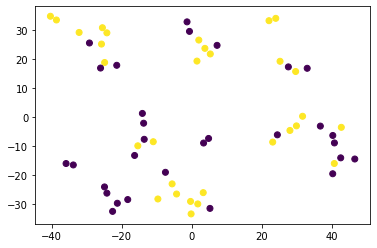

In [50]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=list(labels.numpy()))